## Deep Learning with PyTorch : Neural Style Transfer

In [1]:
!pip install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!git clone https://github.com/parth1620/Project-NST.git

fatal: destination path 'Project-NST' already exists and is not an empty directory.


##  Loading VGG Pretrained Model

In [3]:
import torch
from torchvision import models

vgg = models.vgg16(pretrained = True)
print(vgg)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [4]:
# we are only going to use features from vgg model, we don't want classification part og the model
vgg = vgg.features
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [5]:
# we are not changing weights or biases og pretrained model, so freexe the model
for parameters in vgg.parameters():
  parameters.requires_grad_(False)       #freeze the layers

In [6]:
# use cuda to move variables and model to GPU

# device = torch.device("cude" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

device = torch.device(device)
print(device)

cuda:0


In [7]:
# move model to gpu
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

##  Preprocess image

In [8]:
from PIL import Image
from torchvision import transforms as T

def preprocess(img_path, max_size = 500):
    image = Image.open(img_path).convert('RGB')

    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    img_transform = T.Compose([

            T.Resize(size),
            T.ToTensor(),         #convert img to tensor format, makes img representation axis in this format (channel, height, width)
            T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
    ])

    image = img_transform(image)
    image = image.unsqueeze(0)       #(3, 259, 345) -> (1, 3, 259, 345)
    return image

In [31]:
content_preprocess = preprocess('/content/Project-NST/content10.jpg')
style_preprocess = preprocess('/content/Project-NST/style11.jpg')

content_preprocess = content_preprocess.to(device)
style_preprocess = style_preprocess.to(device)

print("Content shape", content_preprocess.shape)
print("Style shape", style_preprocess.shape)

Content shape torch.Size([1, 3, 487, 487])
Style shape torch.Size([1, 3, 500, 577])


##  Deprocess image

In [32]:
import numpy as np
import matplotlib.pyplot as plt

def deprocess(tensor):
    image = tensor.to('cpu').clone()     #make a copy of img in cpu
    image = image.numpy()                #convert tensor img back to numpy format
    image = image.squeeze(0)             #(1, 3, 259, 345) -> (3, 259, 345)
    image = image.transpose(1,2,0)        #change (channel, height, width) to (height, width, channels)
    image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])      # denormalize the image
    image = image.clip(0,1)

    return image

In [33]:
content_deprocess = deprocess(content_preprocess)
style_deprocess = deprocess(style_preprocess)

print("Deprocess content: ", content_deprocess.shape)
print("Deprocess style: ", style_deprocess.shape)

Deprocess content:  (487, 487, 3)
Deprocess style:  (500, 577, 3)


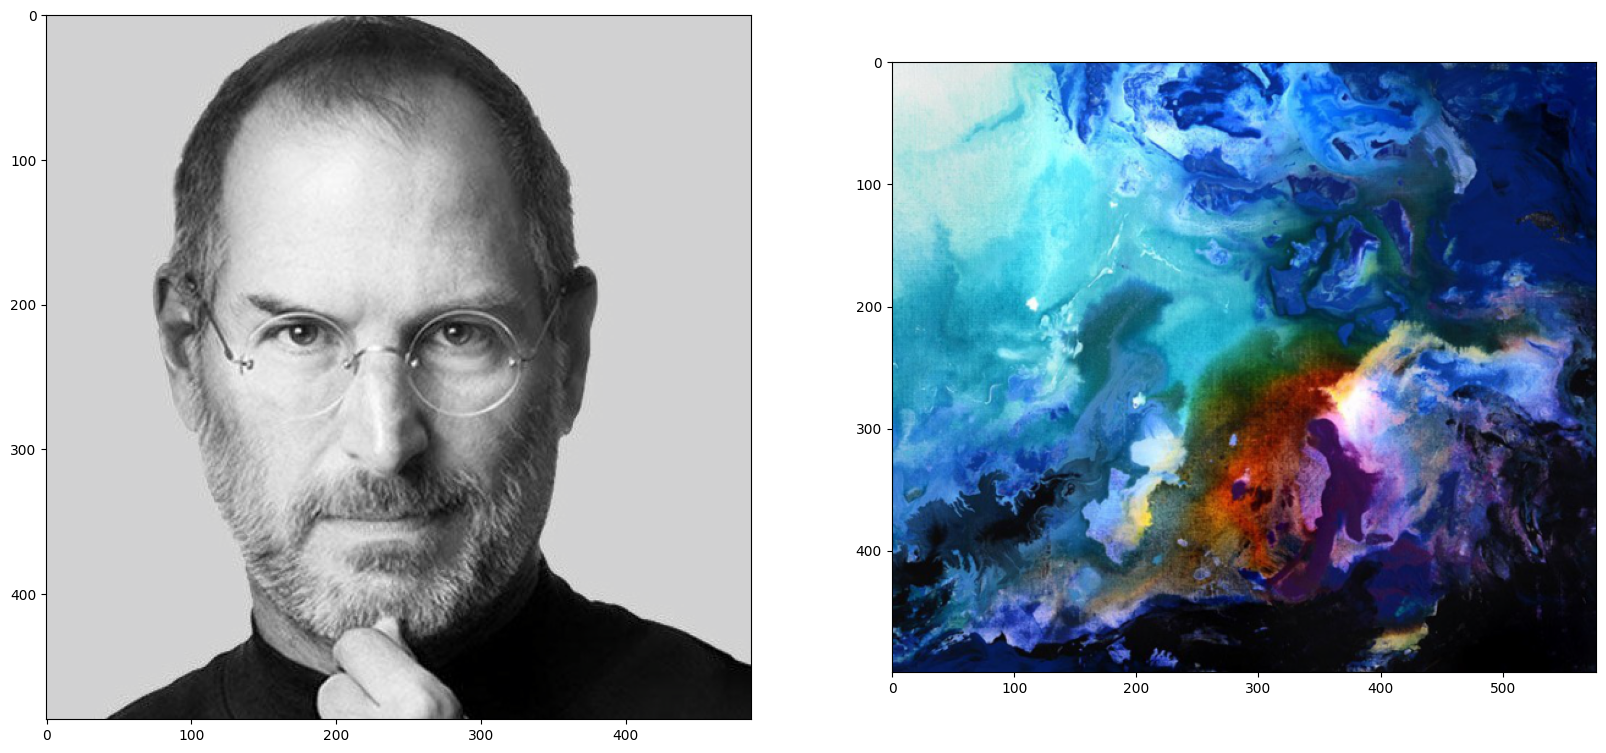

In [34]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,10))

ax1.imshow(content_deprocess)
ax2.imshow(style_deprocess)

##  Get content,style features and create gram matrix

In [35]:
def get_features(image, model):
    layers = {
        '0': 'conv1_1',
        '5': 'conv2_1',
        '10':'conv3_1',
        '19': 'conv4_1',
        '21': 'conv4_2',     #content_feature
        '28': 'conv5_1'
    }

    x = image
    Features =   {}

    for name, layer in model._modules.items():
        x = layer(x)

        if name in layers:
            Features[layers[name]] = x

    return Features

In [36]:
content_features = get_features(content_preprocess, vgg)
style_features = get_features(style_preprocess, vgg)

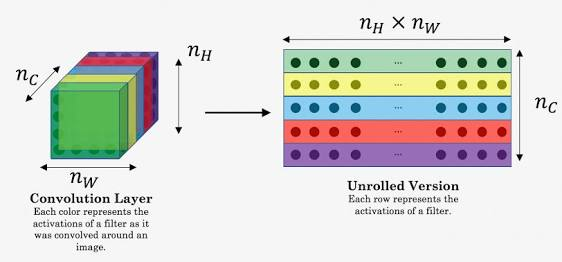

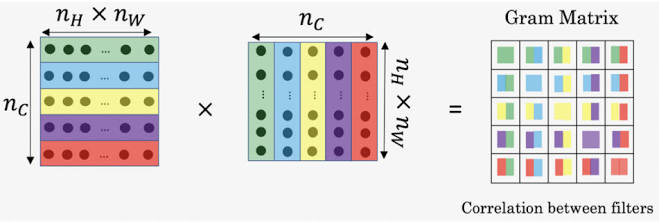

In [37]:
# gram matrix: co-relation between the filters
def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    tensor = tensor.view(c, h*w)    #c-channel, h,w=height, width
    gram = torch.mm(tensor, tensor.t())     # mm- matrix multiplication of tensor and tensor transpose
    return gram

In [38]:
style_grams = {layer : gram_matrix(style_features[layer]) for layer in style_features}

##  Creating Style and Content loss function

In [39]:
import torch
import torch.nn.functional as F
def content_loss(target_conv4_2, content_conv4_2):
    # loss = torch.mean((target_conv4_2 - content_conv4_2) ** 2)
    return F.mse_loss(target_conv4_2, content_conv4_2)

In [40]:
style_weights = {
    'conv1_1': 1.0,
    'conv2_1': 0.75,
    'conv3_1': 0.2,
    'conv4_1': 0.2,
    'conv5_1': 0.2
}

In [41]:
def style_loss(style_weights, target_features, style_grams):
    loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        b, c, h, w = target_feature.shape
        layer_loss = style_weights[layer] * torch.mean((target_gram - style_gram) **2)
        loss += layer_loss / (c*h*w)

    return loss

In [42]:
# initialize target image with content image, you can also initialize target image with random noise
target = content_preprocess.clone().requires_grad_(True).to(device)      #also find gradient of target ro update pixel values
target_feature = get_features(target, vgg)
print("Content loss: ", content_loss(target_feature['conv4_2'], content_features['conv4_2']))
print("Style loss: ", style_loss(style_weights, target_feature, style_grams))


Content loss:  tensor(0., device='cuda:0', grad_fn=<MseLossBackward0>)
Style loss:  tensor(1170.2819, device='cuda:0', grad_fn=<AddBackward0>)


##  Training loop

In [43]:
from torch import optim
optimizer = optim.Adam([target], lr=0.003)

# hyperparameters
alpha = 1
beta = 1e5
epochs = 3000
show_every = 500

In [44]:
def total_loss(c_loss, s_loss, alpha, beta):
    loss = alpha * c_loss + beta * s_loss
    return loss

In [45]:
results = []
for i in range(epochs):
    target_feature = get_features(target, vgg)
    c_loss = content_loss(target_feature['conv4_2'], content_features['conv4_2'])
    s_loss = style_loss(style_weights, target_feature, style_grams)
    t_loss = total_loss(c_loss, s_loss, alpha, beta)

    optimizer.zero_grad()
    t_loss.backward()
    optimizer.step()

    if i % show_every == 0:
        print("Tot loss at epoch {}: {}".format(i,t_loss))
        results.append(deprocess(target.detach()))

Tot loss at epoch 0: 117028184.0
Tot loss at epoch 500: 5785889.5
Tot loss at epoch 1000: 1971871.875
Tot loss at epoch 1500: 1146174.625
Tot loss at epoch 2000: 779325.8125
Tot loss at epoch 2500: 554965.125


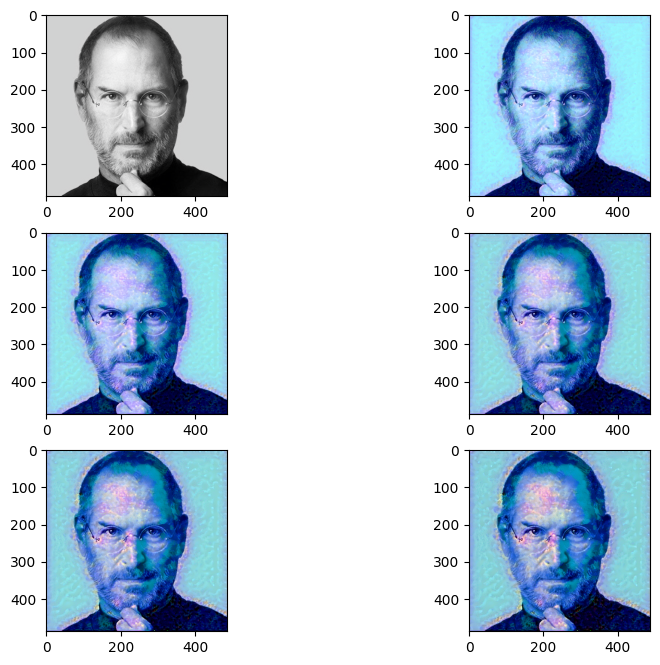

In [46]:
plt.figure(figsize = (10, 8))
for i in range(len(results)):
    plt.subplot(3, 2, i+1)
    plt.imshow(results[i])
plt.show()    

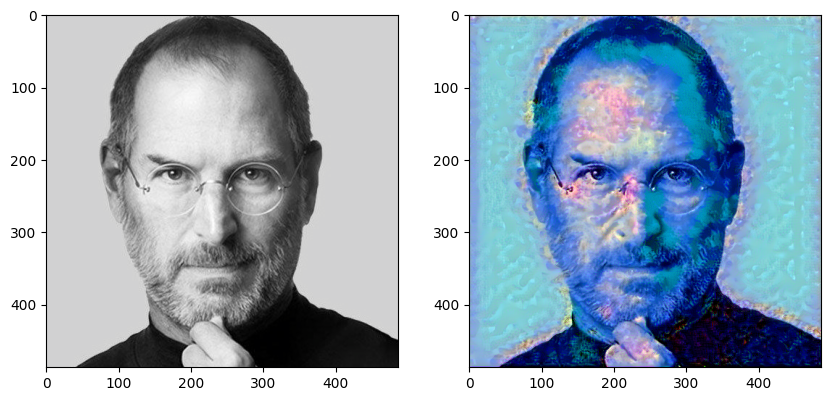

In [47]:
target_copy = deprocess(target.detach())
content_copy = deprocess(content_preprocess)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.imshow(content_copy)
ax2.imshow(target_copy)